### SELF-SUPERVISED REPRESENTATION LEARNING
Apredizaje Auto-Supervisado utilizando una tarea de Pretexto con SimCLR y haciendo fine-tuning con la arquitectura U-NET para Segmentación de Facies Sismicas.

In [1]:
import sys
import os

# Agrega el directorio raíz al PYTHONPATH
sys.path.append(os.path.abspath(".."))

In [2]:
# Others Libraries
import os
import torch
import glob
import numpy as np
from lightning import Trainer
from lightning import seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint

# SSL Technique
from dev.models.ssl.simclr import SimCLRModel
from dev.models.ssl.encoder import ResNetEncoder
from dev.data.data_modules.imagenet import TinyImageNetDataModule

# Downstream
from dev.models.nets.image.unet import UNetLightning
from dev.data.data_modules.f3 import Padding
from dev.data.data_modules.f3 import F3DataModule 

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


In [ ]:
# Check if the dataset path exists
print(os.listdir('/workspaces/Minerva-Dev-Container/shared_data/imagenet/tiny-imagenet-200'))

['val', 'wnids.txt', 'words.txt', 'test', 'train']


In [ ]:
# Create the DataModule
data_module_simclr = TinyImageNetDataModule(
    data_dir='/workspaces/Minerva-Dev-Container/shared_data/imagenet/tiny-imagenet-200',
    batch_size=256,
    num_workers=4
)

# Create the TrainLoader
data_module_simclr.setup()
train_loader_simclr = data_module_simclr.train_dataloader()

for x1, x2 in train_loader_simclr:
    print(x1.shape, x2.shape)  # Verificar las formas
    break

torch.Size([256, 3, 64, 64]) torch.Size([256, 3, 64, 64])


In [9]:
checkpoint_dir = "/workspaces/Minerva-Dev-Container/checkpoints/simclr"
checkpoints = glob.glob(os.path.join(checkpoint_dir, "*.ckpt"))

if checkpoints:  # Comprueba si hay checkpoints disponibles
    latest_checkpoint = max(checkpoints, key=os.path.getctime)
    print(f"Último checkpoint: {latest_checkpoint}")
else:
    print("No se encontraron checkpoints en la carpeta especificada.")

No se encontraron checkpoints en la carpeta especificada.


In [ ]:
# Crear una instancia del encoder
encoder_simclr = ResNetEncoder()

# Configuración del checkpoint
checkpoint_callback = ModelCheckpoint(
    dirpath="/workspaces/Minerva-Dev-Container/checkpoints/simclr",  # Carpeta donde se guardará el checkpoint
    filename="simclr-{epoch:02d}-{loss:.2f}",  # Nombre del archivo
    monitor="train_loss",  # Métrica para guardar el mejor modelo
    save_top_k=1,  # Guarda el mejor modelo
    mode="min"  # Modo de monitoreo ('min' para minimizar la pérdida)
)

# Configuración del entrenador
trainer_simclr = Trainer(
    max_epochs=150, 
    accelerator="gpu", 
    devices=1,
    callbacks=[checkpoint_callback]
    #,resume_from_checkpoint=latest_checkpoint
)

# Instanciar y entrenar el modelo
model_simclr = SimCLRModel(encoder=encoder_simclr)
trainer_simclr.fit(model_simclr, train_loader_simclr)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | encoder         | ResNetEncoder | 11.2 M | train
1 | projection_head | Sequential    | 164 K  | train


Epoch 2:  18%|█▊        | 72/391 [00:09<00:44,  7.20it/s, v_num=45] 

#### FINE-TUNING

In [ ]:
# Define las rutas de tu dataset
train_path = '/workspaces/Minerva-Dev-Container/shared_data/f3_segmentation/images'
annotations_path = '/workspaces/Minerva-Dev-Container/shared_data/f3_segmentation/annotations'

In [ ]:
# Instancia el DataModule y configura el conjunto de datos
data_module_unet = F3DataModule(
    train_path=train_path,
    annotations_path=annotations_path,
    transforms=Padding(target_h_size=256, target_w_size=704),
    batch_size=1
)
data_module_unet.setup(stage="fit")

# Usa el encoder preentrenado de SimCLR
#simclr_model = SimCLRModel.load_from_checkpoint("/workspaces/Minerva-Dev-Container/checkpoints/simclr-epoch=99-loss=0.05.ckpt")
encoder_simclr = model_simclr.encoder

# Instancia el modelo U-Net con 3 canales de entrada
model_unet = UNetLightning(in_channels=3, num_classes=6)
model_unet.encoder = encoder_simclr # Sustituye el encoder del U-Net

# Opcional: Congelar los pesos del encoder
for param in model_unet.encoder.parameters():
    param.requires_grad = False

In [ ]:
# Solo para depuracion

# Carga un lote de datos del DataLoader de entrenamiento
train_dataloader_unet = data_module_unet.train_dataloader()
batch = next(iter(train_dataloader_unet))  # Obtén el primer lote de datos
images, labels = batch

# Realiza un pase hacia adelante
try:
    outputs = model_unet(images)  # Pasa las imágenes a través del modelo
    print("El pase hacia adelante fue exitoso. Dimensiones de salida:", outputs.shape)
except RuntimeError as e:
    print("Error en el pase hacia adelante:", e)

El pase hacia adelante fue exitoso. Dimensiones de salida: torch.Size([1, 6, 256, 704])


In [ ]:
# Establecer la semilla para la reproducibilidad
seed = 42
seed_everything(seed)

# Si prefieres personalizar más el entorno (opcional):
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
checkpoint_dir_u = "/workspaces/Minerva-Dev-Container/checkpoints/unet"
checkpoints_u = glob.glob(os.path.join(checkpoint_dir_u, "*.ckpt"))

if checkpoint_dir_u:  # Comprueba si hay checkpoints disponibles
    latest_checkpoint_u = max(checkpoints, key=os.path.getctime)
    print(f"Último checkpoint: {latest_checkpoint_u}")
else:
    print("No se encontraron checkpoints en la carpeta especificada.")

In [ ]:
# Configuration of the checkpoint
checkpoint_callback_u = ModelCheckpoint(
    dirpath="/workspaces/Minerva-Dev-Container/checkpoints/unet",  # Carpeta donde se guardará el checkpoint
    filename="unet-{epoch:02d}-{loss:.2f}",  # Nombre del archivo
    monitor="train_loss",  # Métrica para guardar el mejor modelo
    save_top_k=1,  # Guarda el mejor modelo
    mode="min"  # Modo de monitoreo ('min' para minimizar la pérdida)
)

In [ ]:
trainer_unet = Trainer(
    max_epochs=150, 
    accelerator="gpu", 
    devices=1,
    callbacks=[checkpoint_callback_u]
    #,resume_from_checkpoint=latest_checkpoint
)
trainer_unet.fit(model_unet, data_module_unet)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name       | Type                   | Params | Mode 
---------------------------------------------------------------
0  | model      | UNet                   | 1.6 M  | train
1  | train_miou | MulticlassJaccardIndex | 0      | train
2  | val_miou   | MulticlassJaccardIndex | 0      | train
3  | test_miou  | MulticlassJaccardIndex | 0      | train
4  | train_mca  | MulticlassAccuracy     | 0      | train
5  | val_mca    | MulticlassAccuracy     | 0      | train
6  | test_mca   | MulticlassAccuracy     | 0      | train
7  | train_pa   | MulticlassAccuracy     | 0      | train
8  | val_pa     | MulticlassAccuracy     | 0      | train
9  | test_pa    | MulticlassAccuracy     | 0      | train
10 | encoder    | ResNetEncoder          | 11.2 M | train
---------------------------------------------------------------
1.6 M     Trainable params
11.2 M    Non-trainable params
12.7 M    Total params
50.925    Total estimated model params size (MB)
106

Epoch 99: 100%|██████████| 992/992 [01:08<00:00, 14.56it/s, v_num=35]      

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 992/992 [01:08<00:00, 14.40it/s, v_num=35]


In [ ]:
# Graficar pérdidas después del entrenamiento
import matplotlib.pyplot as plt

plt.plot(model_unet.train_losses, label='Train Loss')
plt.plot(model_unet.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
trainer_unet.test(model_unet, data_module_unet)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 400/400 [00:13<00:00, 29.52it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_MCA          │     0.713958203792572     │
│          test_PA          │    0.8633603453636169     │
│         test_loss         │     2.179969072341919     │
│         test_mIoU         │    0.5912652015686035     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.179969072341919,
  'test_mIoU': 0.5912652015686035,
  'test_MCA': 0.713958203792572,
  'test_PA': 0.8633603453636169}]

In [ ]:
model_unet.eval()
preds_unet = []
for batch in data_module_unet.predict_dataloader():
    inputs = batch[0].to(model_unet.device)  # Asegúrate de enviar los datos al dispositivo correcto
    with torch.no_grad():
        output = model_unet(inputs)
    preds_unet.append(output)
preds_unet = torch.cat(preds_unet)

#print(preds_unet.shape)  # Verifica la forma de las predicciones

preds_unet_classes = torch.argmax(preds_unet, dim=1)
#print(preds_unet_classes.shape)  # Verifica la forma de las clases predichas

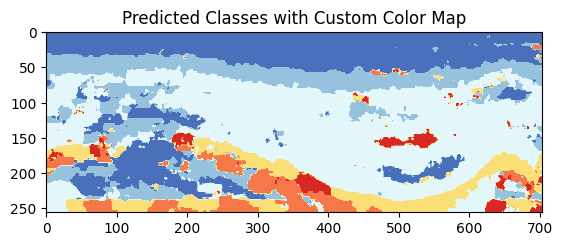

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Define el mapa de colores personalizado
label_cmap = ListedColormap(
    [
        [0.29411764705882354, 0.4392156862745098, 0.7333333333333333],
        [0.5882352941176471, 0.7607843137254902, 0.8666666666666667],
        [0.8901960784313725, 0.9647058823529412, 0.9764705882352941],
        [0.9803921568627451, 0.8745098039215686, 0.4666666666666667],
        [0.9607843137254902, 0.47058823529411764, 0.29411764705882354],
        [0.8470588235294118, 0.1568627450980392, 0.1411764705882353],
    ]
)

# Visualizar la primera predicción con el mapa de colores personalizado
plt.imshow(preds_unet_classes[0].cpu().numpy(), cmap=label_cmap)
plt.title("Predicted Classes with Custom Color Map")
plt.show()

### SUPERVISED LEARNING
Apredizaje Supervisado utilizando la arquitectura U-NET para Segmentación de Facies Sismicas.

In [ ]:
# Define las rutas de tu dataset
train_path = '/workspaces/Minerva-Dev-Container/shared_data/f3_segmentation/images'
annotations_path = '/workspaces/Minerva-Dev-Container/shared_data/f3_segmentation/annotations'

In [ ]:
# Instancia el DataModule y configura el conjunto de datos
data_module_s = F3DataModule(
    train_path=train_path,
    annotations_path=annotations_path,
    transforms=Padding(target_h_size=256, target_w_size=704),
    batch_size=1
)
data_module_s.setup(stage="fit")

# Instancia el modelo U-Net con 3 canales de entrada
model_s = UNetLightning(in_channels=3, num_classes=6)

In [ ]:
# Solo para depuracion

# Carga un lote de datos del DataLoader de entrenamiento
train_dataloader = data_module_s.train_dataloader()
batch = next(iter(train_dataloader))  # Obtén el primer lote de datos
images, labels = batch

# Realiza un pase hacia adelante
try:
    outputs = model_s(images)  # Pasa las imágenes a través del modelo
    print("El pase hacia adelante fue exitoso. Dimensiones de salida:", outputs.shape)
except RuntimeError as e:
    print("Error en el pase hacia adelante:", e)

El pase hacia adelante fue exitoso. Dimensiones de salida: torch.Size([1, 6, 256, 704])


In [ ]:
# Establecer la semilla para la reproducibilidad
seed = 42
seed_everything(seed)

# Si prefieres personalizar más el entorno (opcional):
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
checkpoint_dir_s = "/workspaces/Minerva-Dev-Container/checkpoints/unet_s"
checkpoints_s = glob.glob(os.path.join(checkpoint_dir_s, "*.ckpt"))

if checkpoint_dir_s:  # Comprueba si hay checkpoints disponibles
    latest_checkpoint_s = max(checkpoints, key=os.path.getctime)
    print(f"Último checkpoint: {latest_checkpoint_s}")
else:
    print("No se encontraron checkpoints en la carpeta especificada.")

In [ ]:
# Configuration of the checkpoint
checkpoint_callback_s = ModelCheckpoint(
    dirpath="/workspaces/Minerva-Dev-Container/checkpoints/unet_s",  # Carpeta donde se guardará el checkpoint
    filename="unets-{epoch:02d}-{loss:.2f}",  # Nombre del archivo
    monitor="train_loss",  # Métrica para guardar el mejor modelo
    save_top_k=1,  # Guarda el mejor modelo
    mode="min"  # Modo de monitoreo ('min' para minimizar la pérdida)
)

In [ ]:
trainer_s = Trainer(
    max_epochs=150, 
    accelerator="gpu", 
    devices=1,
    callbacks=[checkpoint_callback_s]
    #,resume_from_checkpoint=latest_checkpoint
)
trainer_s.fit(model_s, data_module_s)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                   | Params | Mode 
--------------------------------------------------------------
0 | model      | UNet                   | 1.6 M  | train
1 | train_miou | MulticlassJaccardIndex | 0      | train
2 | val_miou   | MulticlassJaccardIndex | 0      | train
3 | test_miou  | MulticlassJaccardIndex | 0      | train
4 | train_mca  | MulticlassAccuracy     | 0      | train
5 | val_mca    | MulticlassAccuracy     | 0      | train
6 | test_mca   | MulticlassAccuracy     | 0      | train
7 | train_pa   | MulticlassAccuracy     | 0      | train
8 | val_pa     | MulticlassAccuracy     | 0      | train
9 | test_pa    | MulticlassAccuracy     | 0      | train
--------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.219  

Epoch 99: 100%|██████████| 992/992 [00:21<00:00, 45.50it/s, v_num=36]      

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 992/992 [00:22<00:00, 45.02it/s, v_num=36]


In [ ]:
# Graficar pérdidas después del entrenamiento
import matplotlib.pyplot as plt

plt.plot(model_s.train_losses, label='Train Loss')
plt.plot(model_s.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
trainer_s.test(model_s, data_module_s)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 400/400 [00:13<00:00, 30.34it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_MCA          │    0.7117792367935181     │
│          test_PA          │     0.863506555557251     │
│         test_loss         │    1.8114826679229736     │
│         test_mIoU         │    0.5923401117324829     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.8114826679229736,
  'test_mIoU': 0.5923401117324829,
  'test_MCA': 0.7117792367935181,
  'test_PA': 0.863506555557251}]

In [ ]:
# Solo para depuracion

for batch in data_module_s.predict_dataloader():
    print(batch[0].shape)  # Verifica las dimensiones de las imágenes
    break

torch.Size([1, 3, 256, 704])


In [ ]:
model_s.eval()
preds = []
for batch in data_module_s.predict_dataloader():
    inputs = batch[0].to(model_s.device)  # Asegúrate de enviar los datos al dispositivo correcto
    with torch.no_grad():
        output = model_s(inputs)
    preds.append(output)
preds = torch.cat(preds)

#print(preds.shape)  # Verifica la forma de las predicciones

preds_classes = torch.argmax(preds, dim=1)
#print(preds_classes.shape)  # Verifica la forma de las clases predichas

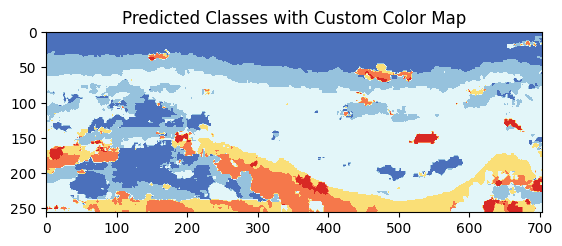

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Define el mapa de colores personalizado
label_cmap = ListedColormap(
    [
        [0.29411764705882354, 0.4392156862745098, 0.7333333333333333],
        [0.5882352941176471, 0.7607843137254902, 0.8666666666666667],
        [0.8901960784313725, 0.9647058823529412, 0.9764705882352941],
        [0.9803921568627451, 0.8745098039215686, 0.4666666666666667],
        [0.9607843137254902, 0.47058823529411764, 0.29411764705882354],
        [0.8470588235294118, 0.1568627450980392, 0.1411764705882353],
    ]
)

# Visualizar la primera predicción con el mapa de colores personalizado
plt.imshow(preds_classes[0].cpu().numpy(), cmap=label_cmap)
plt.title("Predicted Classes with Custom Color Map")
plt.show()